In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import sklearn
import numpy as np
from scipy.stats import lognorm
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import chi2

In [ ]:
# fetch dataset 
air_quality = fetch_ucirepo(id=360)
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets
df = pd.concat([X, y], axis=1)
df = df.drop('Date', axis=1)
df = df.drop('Time', axis=1)
# print(df.head(20))
df = df.apply(pd.to_numeric, errors='coerce')
neg = (df == -200).any(axis=1).sum()
print(f" % precent of rows with at least 1 negative value: {neg / len(df) * 100}")
# since 91% of rows are like this, we can't delete the rows, so we have to impute
# avg of forward and backward fill instead of using just mean value of colum
df = df.replace(-200, pd.NA)
df = (df.ffill() + df.bfill()) / 2
print(df.head(20))

 % precent of rows with at least 1 negative value: 91.16169712514694
    CO(GT)  PT08.S1(CO) NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.60       1360.0    150.0      11.9         1046.0    166.0   
1     2.00       1292.0    112.0       9.4          955.0    103.0   
2     2.20       1402.0     88.0       9.0          939.0    131.0   
3     2.20       1376.0     80.0       9.2          948.0    172.0   
4     1.60       1272.0     51.0       6.5          836.0    131.0   
5     1.20       1197.0     38.0       4.7          750.0     89.0   
6     1.20       1185.0     31.0       3.6          690.0     62.0   
7     1.00       1136.0     31.0       3.3          672.0     62.0   
8     0.90       1094.0     24.0       2.3          609.0     45.0   
9     0.60       1010.0     19.0       1.7          561.0     33.0   
10    0.65       1011.0     14.0       1.3          527.0     21.0   
11    0.70       1066.0      8.0       1.1          512.0     16.0   
12    0.70       1052

/var/folders/h3/srj0ks150b74jtpr2zl0w3d40000gn/T/ipykernel_73994/3123187785.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = (df.ffill() + df.bfill()) / 2


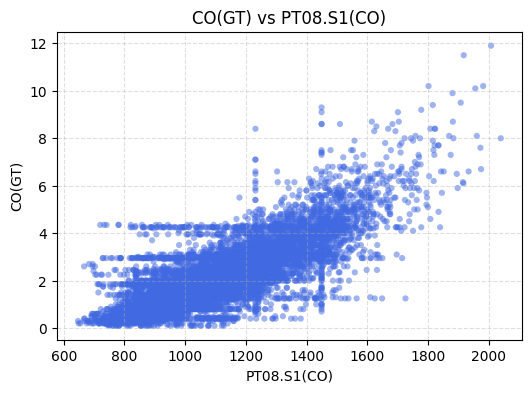

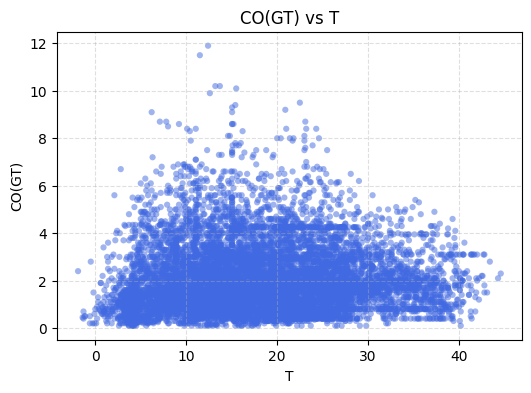

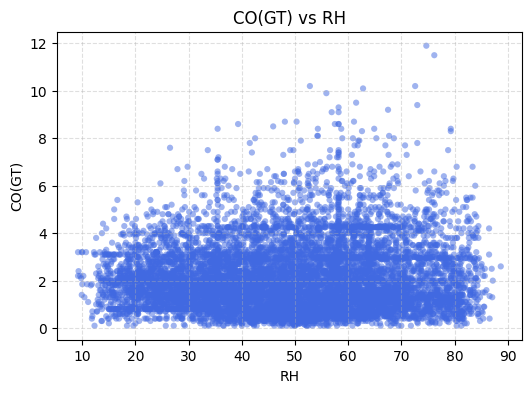

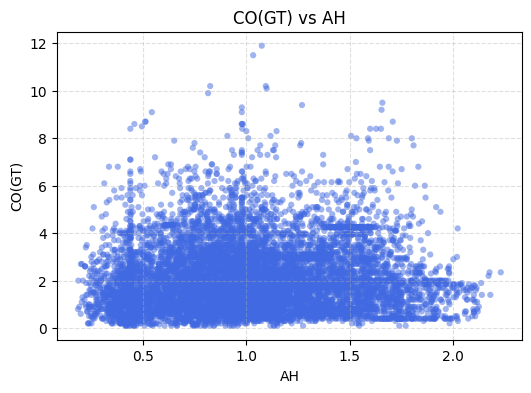

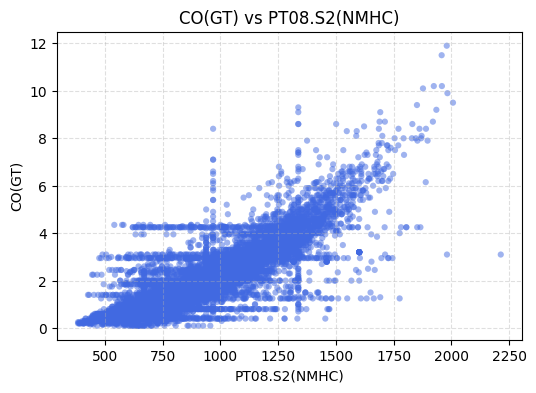

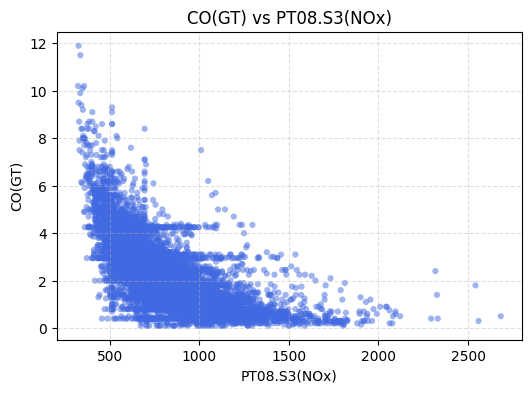

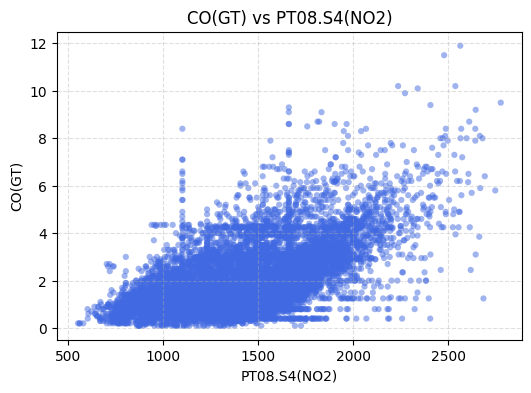

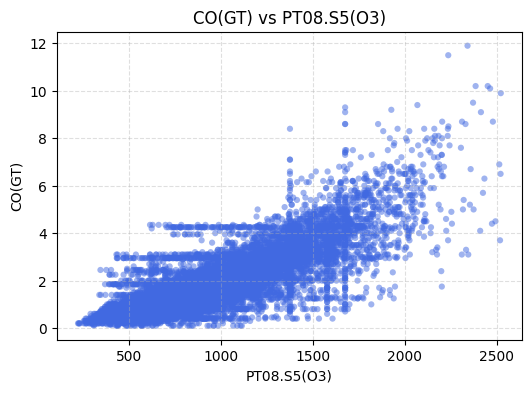

In [ ]:
# non target variables vs CO(GT) plots
y = 'CO(GT)'
variables = [
    'PT08.S1(CO)', 'T', 'RH', 'AH',
    'PT08.S2(NMHC)', 'PT08.S3(NOx)',
    'PT08.S4(NO2)', 'PT08.S5(O3)'
]

for x in variables:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[x], df[y], s=20, alpha=0.5, color='royalblue', edgecolors='none')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} vs {x}')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()


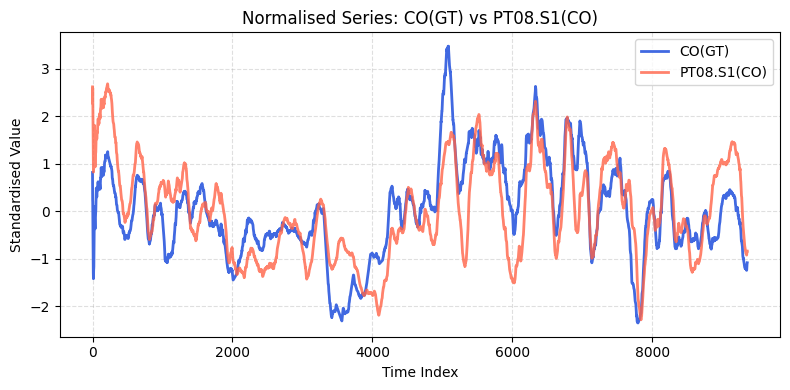

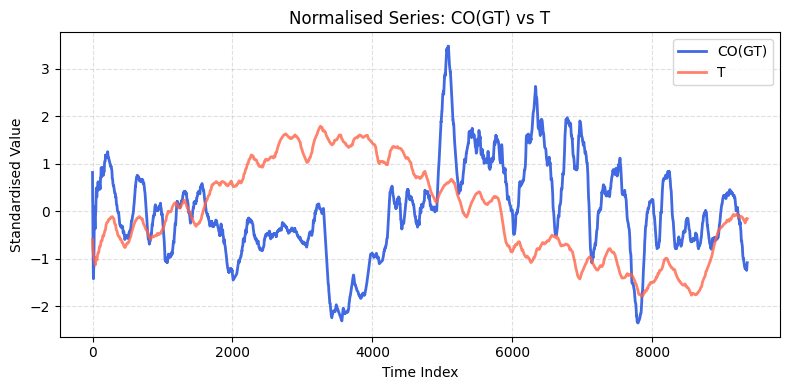

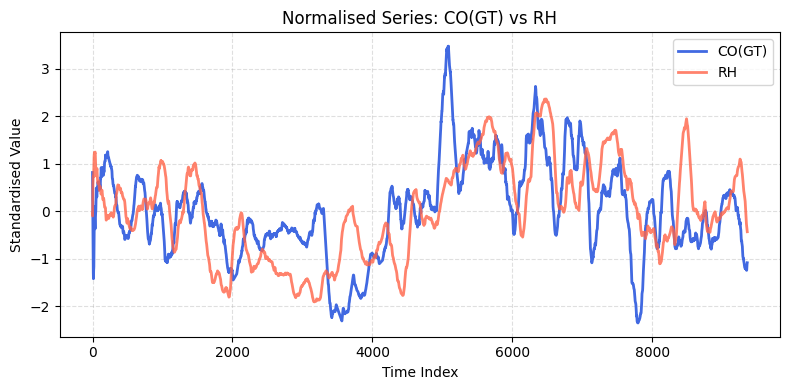

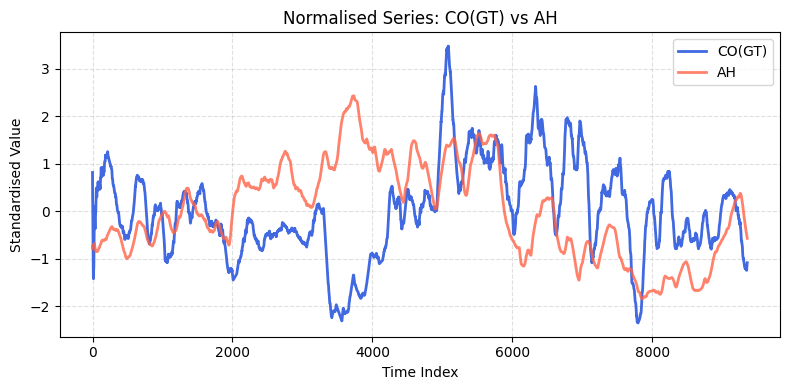

Lag correlations with current CO(GT):
Lag-1: 0.860
Lag-2: 0.660
Lag-3: 0.497


In [ ]:
# time series plots with moving averages
variables = ['PT08.S1(CO)', 'T', 'RH', 'AH']
target = 'CO(GT)'

for col in variables:
    plt.figure(figsize=(8,4))

    target_smooth = df[target].rolling(window=24*7, min_periods=1).mean()
    target_norm = (target_smooth - target_smooth.mean()) / target_smooth.std()
    
    feature_smooth = df[col].rolling(window=24*7, min_periods=1).mean()
    feature_norm = (feature_smooth - feature_smooth.mean()) / feature_smooth.std()
    
    plt.plot(df.index, target_norm, label=target, color='royalblue', linewidth=2)
    plt.plot(df.index, feature_norm, label=col, color='tomato', linewidth=2, alpha=0.8)
    plt.title(f'Normalised Series: {target} vs {col}')
    plt.xlabel('Time Index')
    plt.ylabel('Standardised Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
    
lags = [1, 2, 3]
print("Lag correlations with current CO(GT):")
for lag in lags:
    correlation = df['CO(GT)'].corr(df['CO(GT)'].shift(lag))
    print(f"Lag {lag}: {correlation:.3f}")


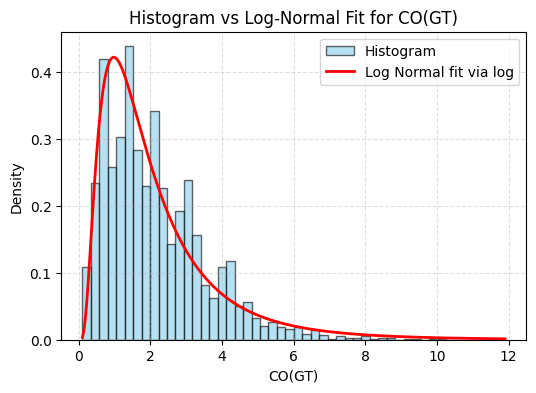

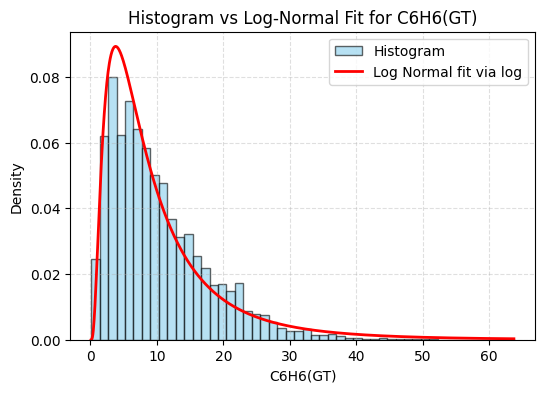

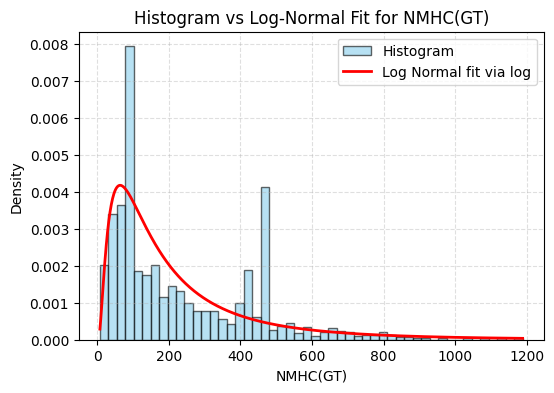

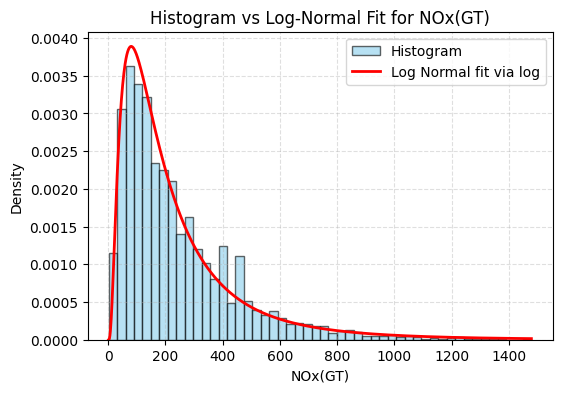

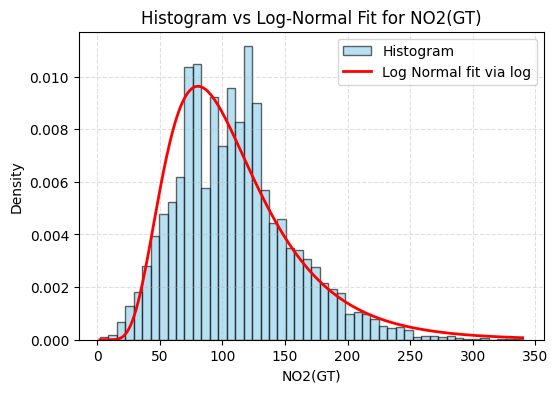

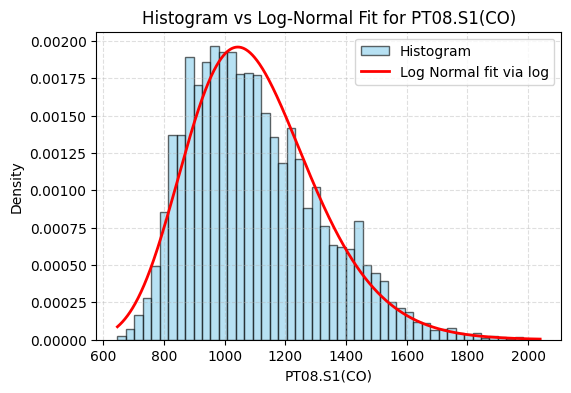

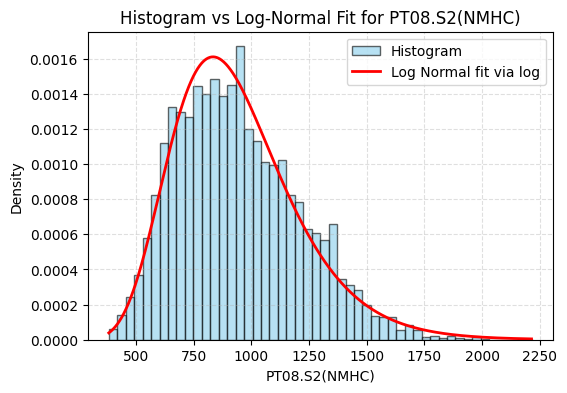

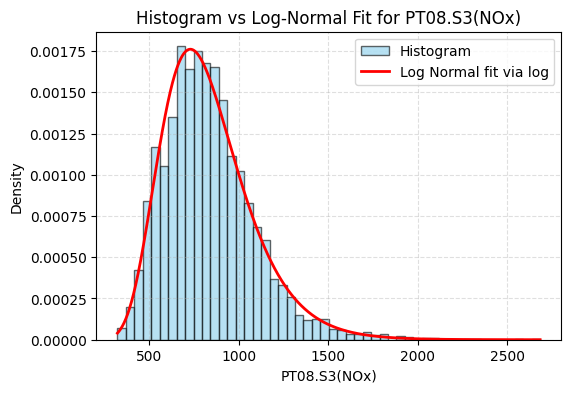

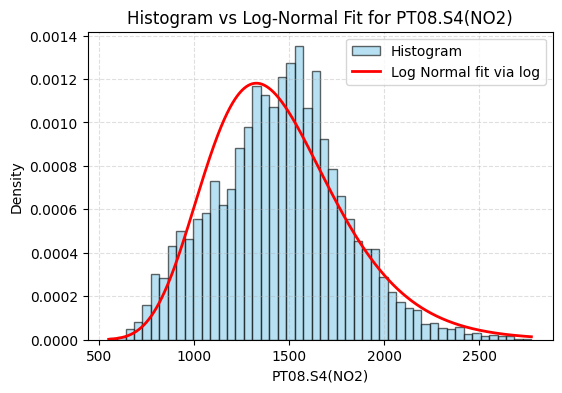

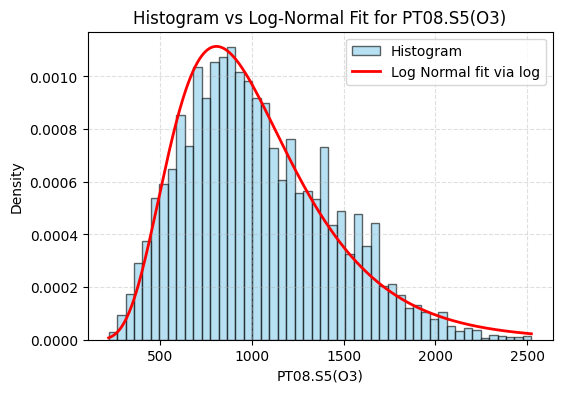

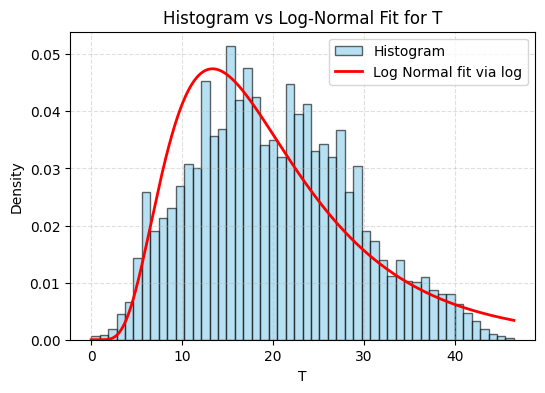

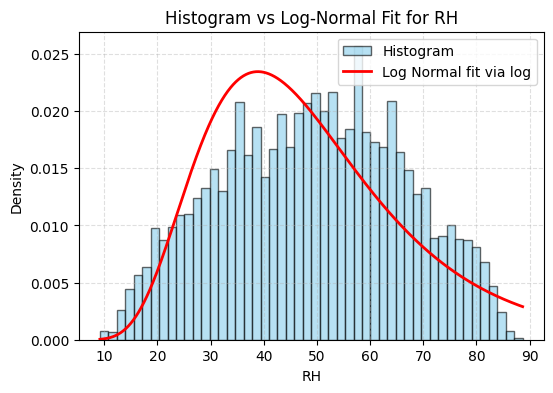

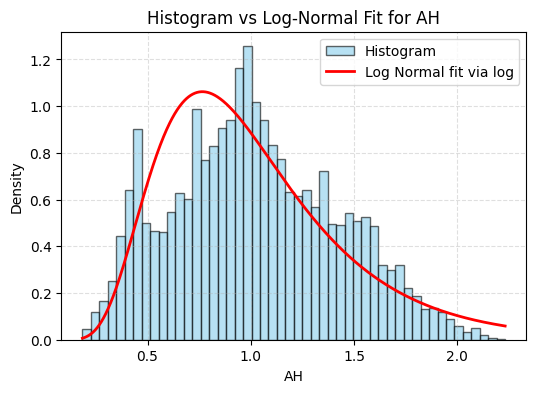

In [ ]:
# distribution plots

variables = [
    'CO(GT)', 'C6H6(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)',
    'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
    'T', 'RH', 'AH'
]

for y in variables:

    data = pd.to_numeric(df[y], errors='coerce').dropna()
    # +ve vals only
    if (data <= 0).any():
        data = data + abs(data.min()) + 1e-6
    
    # log(X) ~ Normal ==> X ~ log normal
    log_data = np.log(data)
    mu, sigma = norm.fit(log_data)
    x = np.linspace(data.min(), data.max(), 1000)
    pdf = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
    
    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Histogram')
    plt.plot(x, pdf, 'r', lw=2, label='Log Normal fit via log')
    xlabel = f"{y} (+{shift:.6f} shift)" if shift > 0 else y
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(f'Histogram vs Log-Normal Fit for {y}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()